# Planar graphs

### A note about planarity testing and embeddings in Sage

In [2]:
G = Graph('D~[')

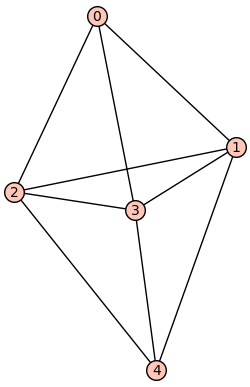

In [3]:
G.plot()

G is planar graph. How do we get its embedding and combinatorial embedding (clockwise ordering of neighbors at each vertex)?
`G.is_planar(set_embedding=True, set_pos=True)` checks for planarity and, optionally, sets coordinates and combinatorial embedding.

In [4]:
G.is_planar(set_embedding=True, set_pos=True)

True

Subsequent plot gives planar drawing

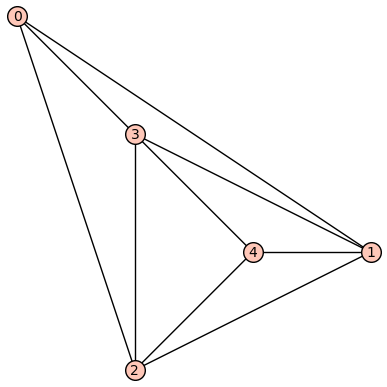

In [5]:
G.plot()

For each vertex, we can now get its neighbors in the planar embedding (clockwise) ...

In [6]:
emb = G.get_embedding()
emb

{0: [1, 3, 2], 1: [2, 4, 3, 0], 2: [0, 3, 4, 1], 3: [0, 1, 4, 2], 4: [1, 2, 3]}

... and from an embedding its faces (each face is a list of edges on it)

In [7]:
G.faces(emb)

[[(0, 1), (1, 2), (2, 0)],
 [(0, 2), (2, 3), (3, 0)],
 [(0, 3), (3, 1), (1, 0)],
 [(1, 3), (3, 4), (4, 1)],
 [(1, 4), (4, 2), (2, 1)],
 [(2, 4), (4, 3), (3, 2)]]

Another example:

In [8]:
H = Graph({0:[1,2,3], 1:[4,5], 2:[6], 3:[4,6], 4:[7], 5:[7], 6:[7]})
H.is_planar(set_embedding=True, set_pos=True)

True

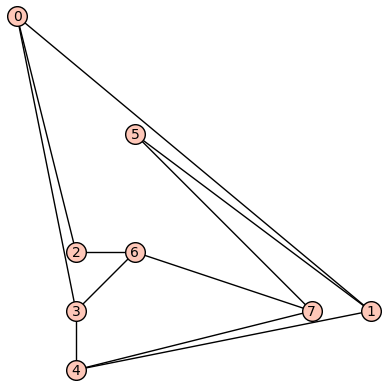

In [9]:
H.plot()

In [10]:
H.get_embedding()

{0: [1, 2, 3],
 1: [4, 5, 0],
 2: [0, 6],
 3: [0, 6, 4],
 4: [3, 7, 1],
 5: [1, 7],
 6: [2, 7, 3],
 7: [5, 4, 6]}

In [11]:
H.faces()

[[(0, 1), (1, 4), (4, 3), (3, 0)],
 [(0, 2), (2, 6), (6, 7), (7, 5), (5, 1), (1, 0)],
 [(0, 3), (3, 6), (6, 2), (2, 0)],
 [(1, 5), (5, 7), (7, 4), (4, 1)],
 [(3, 4), (4, 7), (7, 6), (6, 3)]]

# Graph Drawing

We will write "iterative" methods for drawing graphs. General idea is to:
1. Start with a random drawing
2. Iteratively improve the drawing

## Method 1: "Mass center"

Write functions:
* `move_vertex_c(G, v, pos)`
  Where G is graph, v is a vertex in G, pos is a dictionary of positions for each vertex. It should move position of v to the mass center of its neighbors; that is $pos(v) = 1/|N(v)| \sum_{u \in N(v)} pos(u)$.
  
* `draw_graph_c(G, F, iters)` 
  Where G is graph, F is a list of fixed vertices, iters is a number of iterations. Function should 
  1. Draw positions of vertices of F on a circle (with radius 1, i.e., set positions of F to vertices of a regular polygon).
  2. Other vertices, V(G)\F, set to random positions in square $[-0.5, 0.5] \times [-0.5, 0.5]$.
  3. Use function `move_vertex_c` to change position of each vertex V(G)\F.
  4. Repeat step 3 `iters` times.
  

In [12]:
def find_cycle(G0):
    """
    An ad-hoc function to find some cycle in a graph, provided that G is 2-connected
    """
    G = G0.copy()
    e = G.edges(sort=False)[0]
    G.delete_edge(e)
    return G.shortest_path(e[0], e[1])

In [13]:
def move_vertex_c(G, v, pos):
    x = 0
    y = 0
    for u in G.neighbors(v):
        xv, yx = pos[u]
        x += xv
        y += yx
    x = x / len(G.neighbors(v))
    y = y / len(G.neighbors(v))
    pos[v] = (x, y)
    

def draw_graph_c(G, F, iters):
    """
    G - graph
    F - cycles
    iters - are a number of total iterations
    """
    pos = {}
    n = len(F)
    for i, v in enumerate(F):
        pos[v] = (math.cos(2*math.pi*i/n), math.sin(2*math.pi*i/n))
    
    for c in G.vertices():
        if c not in F:
            pos[c] = [random()-0.5, random()-.5]
    
    for i in range(iters):
        for v in G.vertices():
            if v not in F:
                move_vertex_c(G, v, pos)
    
    G.set_pos(pos)
    return G.plot(vertex_labels = False, vertex_size = 10)

In [14]:
random()-0.5

-0.107583471319502

In [15]:
math.pi

3.141592653589793

In [16]:
G = graphs.BuckyBall()

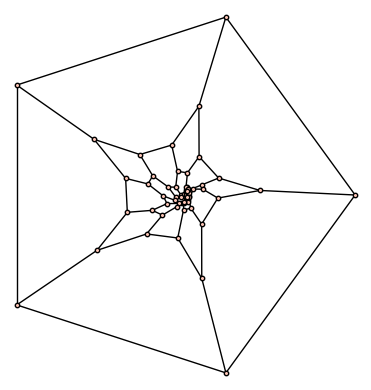

In [17]:
draw_graph_c(G, find_cycle(G), 5)

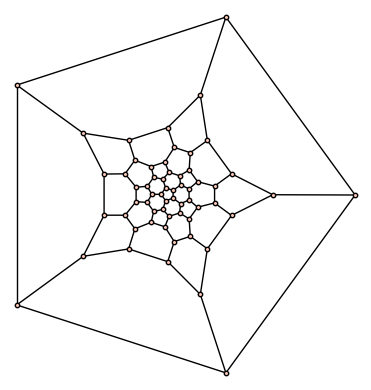

In [18]:
draw_graph_c(G, find_cycle(G), 100)

## Method 2: Move vertices using force

Write functions:
* `move_vertex_f(G, v, pos, k)`
  Similar to `move_vertex_c`, just use "forces" to move vertex $v$. Each edge $vu$ ($u$ is a neighbor of $v$) acts like a "spring" and acts with force $\vec{F} = k\: \vec{\delta}$ where $\vec{\delta} = \vec{u} - \vec{v}$ (Hooke's law) and $k$ is characteristic of the spring (razteznostni koeficient in Slovene). That is: $pos(v) = pos(v) + \sum_{u \in N(v)} k (pos(u) - pos(v))$.
  
* `draw_graph_f(G, F, k, iters)` same as `draw_graph_c`, just use `move_vertex_f` instead of `move_vertex_c`.


In [19]:
def move_vertex_f(G, v, pos, k):
    x = 0
    y = 0
    v_x, v_y = pos[v]
    for u in G.neighbors(v):
        u_x, u_y = pos[u]
        x += (u_x - v_x)*k
        y += (u_y - v_y)*k
    pos[v] = (v_x + x, v_y + y)


def draw_graph_f(G, F, k, iters):
    pos = {}
    n = len(F)
    for i, v in enumerate(F):
        pos[v] = (math.cos(2*math.pi*i/n), math.sin(2*math.pi*i/n))
    
    for c in G.vertices():
        if c not in F:
            pos[c] = [random()-0.5, random()-.5]
    
    for i in range(iters):
        for v in G.vertices():
            if v not in F:
                move_vertex_f(G, v, pos, k)
    
    G.set_pos(pos)
    return G.plot(vertex_labels = False, vertex_size = 10)


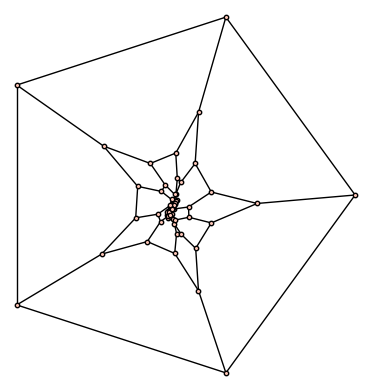

In [20]:

draw_graph_f(G, find_cycle(G), 0.09, 30)

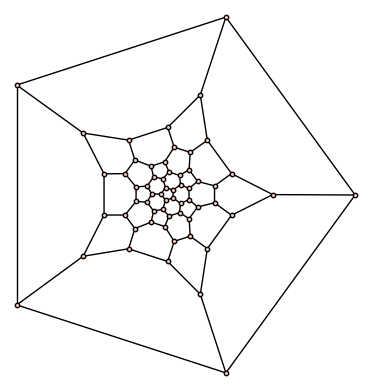

In [21]:
draw_graph_f(G, find_cycle(G), 0.5, 30)

## Method 3: Spring Embedder

For both methods above we required a cycle to be selected before fixing its coordinates. But this is not "practical". Can we do without this?

Write functions:
* `move_vertex_se(G, v, pos, k, e)`
  Similar to `move_vertex_f`, each edge $vu$ ($u$ is a neighbor of $v$) of  acts like a "spring" and acts with force $
  \vec{F} = k\: \vec{\delta}$ where $\vec{\delta} = \vec{u} - \vec{v}$. Additionally: vertices also act in a "repulsive way" with force $\vec{R} = -e\: \vec{\delta}/|\vec{\delta}|^2$ for all $u \neq v$. With the repulsive force we do not allow two vertices to be too close, since the force is is inversely proportional to the square of the distance between them!
  
* `draw_graph_se(G, k, e, iters)` similar to `draw_graph_f`, just use `move_vertex_se` instead of `move_vertex_f`. Note that there are no fixed vertices. Initially, for each vertex, choose a random position in square $[-0.5, 0.5] \times [-0.5, 0.5]$. 

In [22]:
def move_vertex_se(G, v, pos, k, e):
    x1 = 0
    y1 = 0
    xr = 0
    yr = 0
    v_x, v_y = pos[v]

    for u in G.neighbors(v):
        u_x, u_y = pos[u]
        x1 += (u_x - v_x)*k
        y1 += (u_y - v_y)*k
    for u in G:
        if u != v:
            u_x, u_y = pos[u]
            temp_x = (u_x - v_x)
            temp_y = (u_y - v_y)
            xr += (-e) * (temp_x/(temp_x**2 + temp_y**2))
            yr += (-e) * (temp_y/(temp_x**2 + temp_y**2))
    
    pos[v] = (v_x + x1 + xr, v_y + y1 + yr)



def draw_graph_se(G, k, e, iters):
    pos = {}
    
    for c in G.vertices():
        pos[c] = [random()-0.5, random()-.5]
    
    for i in range(iters):
        for v in G.vertices():
            move_vertex_se(G, v, pos, k, e)
    
    G.set_pos(pos)
    return G.plot(vertex_labels = False, vertex_size = 10)

**Try to find $k$ and $e$ such that the result will be "nice"**

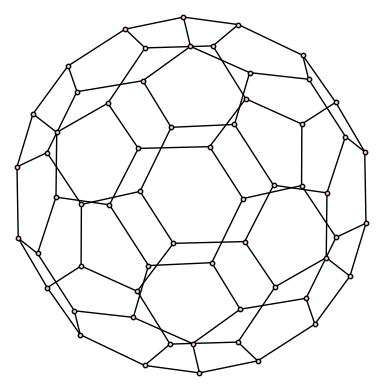

In [23]:
draw_graph_se(G, 0.5, 0.1, 100)

### More examples

$k$ and $e$ from above should work for most of examples below!

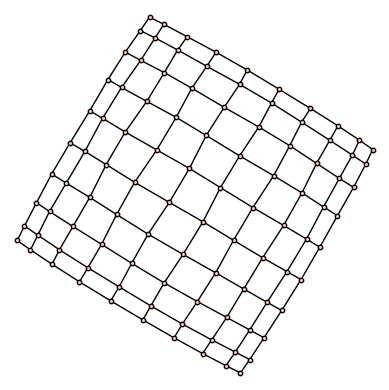

In [24]:
draw_graph_se(graphs.Grid2dGraph(10, 10), 0.5, 0.1, 100)

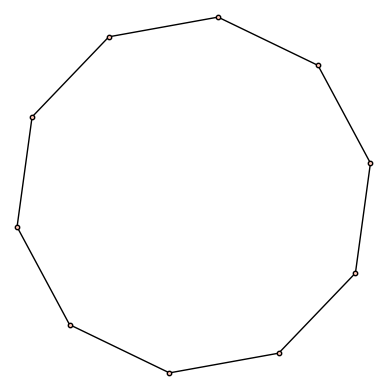

In [25]:
draw_graph_se(graphs.CycleGraph(10), 0.5, 0.1,  100)

In [26]:
C10 = graphs.CycleGraph(10)
C4 = graphs.CycleGraph(4)

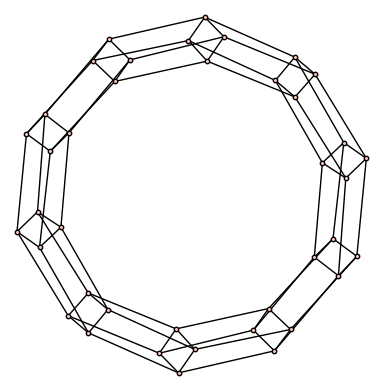

In [27]:
draw_graph_se(C10.cartesian_product(C4), 0.3, 0.1,  100)

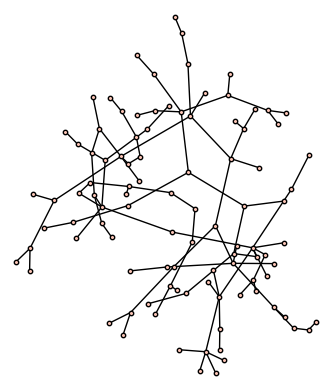

In [28]:
draw_graph_se(graphs.RandomTree(100), 0.03, 0.5,  100)

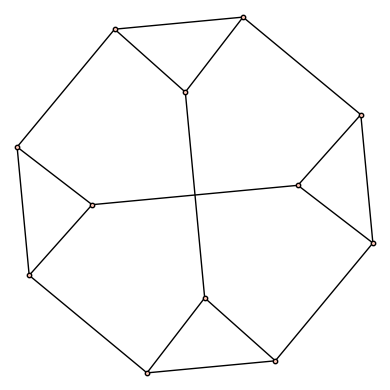

In [29]:
draw_graph_se(Graph('KhEM@_K?_A_F'), 0.5, 0.1,  100)

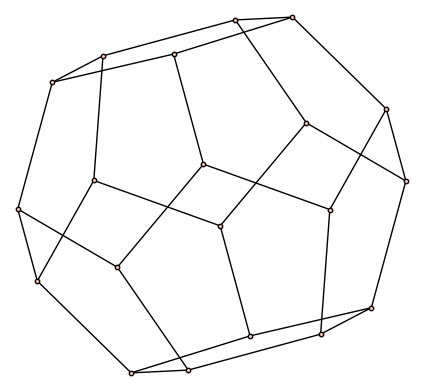

In [30]:
draw_graph_se(Graph('ShCHGD@?K?_@?@?C_GGG@??cG?G?GK_?C'), 0.5, 0.1,  100)

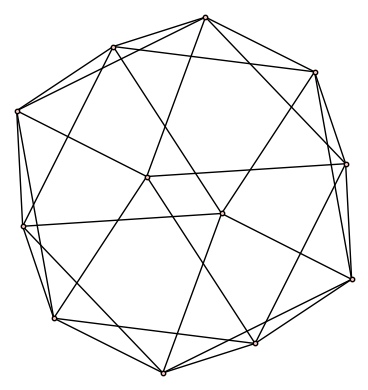

In [31]:
draw_graph_se(Graph('KhFJ{B`KWqph'), 0.1, 0.1,  100)

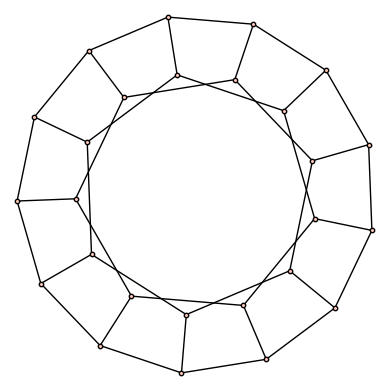

In [32]:
draw_graph_se(Graph('YhCGGC@?G?_@_@_?G?@?AC?GG?OG?OC?G@?A?G?O?_@?@?A?@OA??g@?'), 0.5, 0.1,  100)

## Method 4: Laplacian matrix eigenvectors

Let $G$ be a connected undirected graph. Laplacian matrix (or Kirchhoff matrix) is defined as a matrix $L = D - M$ where $D$ is the degree matrix, $d_{ii} = \deg(v_i)$ and $d_{ij} = 0$ for $i \neq j$, and $M$ is the adjacency matrix of $G$. That means that $L$ is an 
$n \times n$ matrix ($n$ is the number of vertices) where
$$
  l_{ij} = \begin{cases}
   \deg(v_i) & i = j \\
   -1 & \text{$i \neq j$ and $i$ is adjacent to $j$} \\
   0 & \text{otherwise}.
  \end{cases}
$$
(In Sage you can use method `laplacian_matrix`.)



Implement the following graph drawing algorithm
* Calculate the eigenvectors of the Laplacian matrix (in Sage use `G.eigenvectors(laplacian=True)` see the [documentation](https://doc.sagemath.org/html/en/reference/graphs/sage/graphs/generic_graph.html#sage.graphs.generic_graph.GenericGraph.laplacian_matrix));
* Sort eigenvectors ascending by the corresponding eigenvalue;
* Orthogonalize (and normalize) them (e.g., using [Gram-Schmidt method](https://doc.sagemath.org/html/en/reference/matrices/sage/matrix/matrix2.html#sage.matrix.matrix2.Matrix.gram_schmidt));
* take two eigenvectors $e_i = (e_{i0}, e_{i1}, \dots, e_{in-1})$ and $e_j = (e_{j0}, e_{j1}, \dots, e_{jn-1})$ where $0 < i < j$ are parameters of the algorithm;
* Set coordinates of the vertices to $(e_{i0}, e_{j0}), (e_{i1}, e_{j1}), \dots$.

In [33]:
def draw_graph_ev(G, ev=[1,2]):
    """
    Implements graph drawing algorithm using eigenvectors (listed in parameter ev) of the Laplacian matrix
    """
    eigenvectors = [] 
    egg = G.eigenvectors(laplacian=True)
    for e in egg:
        eigenvalue = e[0]
        for i in e[1]:
            eigenvectors.append((eigenvalue,i))
    
    sorted_eigenvectors = sorted(eigenvectors, key=lambda x: x[0])

    # Extract the eigenvectors and convert them into a matrix
    sorted_array = matrix([x[1] for x in sorted_eigenvectors])

    # Apply the Gram-Schmidt process
    sorted_array, _ = sorted_array.gram_schmidt(orthonormal=True)
    

    ei = sorted_array[ev[0]]
    ej = sorted_array[ev[1]]
    pos = {}
    for i, v in enumerate(G.vertices()):
        pos[v] = (ei[i], ej[i])
    
    G.set_pos(pos)
    return G.plot()

### Examples

Try to find the parameter `ev` to get the best result (it depends on each graph) for the following graphs (you should never use the first eigenvector, since it is an all-ones vector).

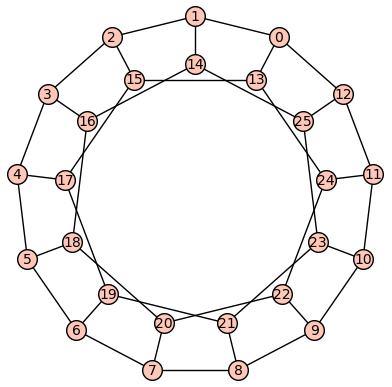

In [34]:
G1 = Graph('YhCGGC@?G?_@_@_?G?@?AC?GG?OG?OC?G@?A?G?O?_@?@?A?@OA??g@?')
draw_graph_ev(G1)

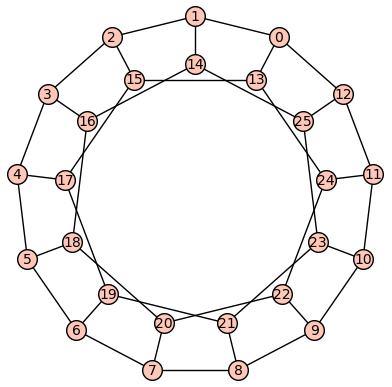

In [35]:
G2 = Graph('XhEAHCPAGG?P?P?G_AG?O?@C?AG?AG?@C??O??AG??G_??P???P')
draw_graph_ev(G1)

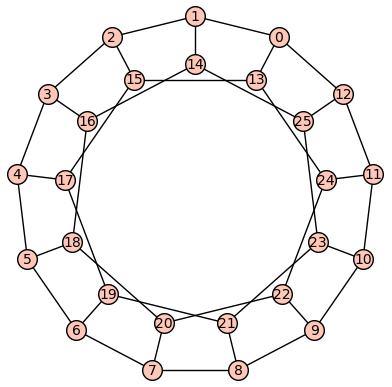

In [36]:
G3 = Graph('ShCHGD@?K?_@?@?C_GGG@??cG?G?GK_?C')
draw_graph_ev(G1)

In [37]:
G4 = graphs.RandomTree(20)

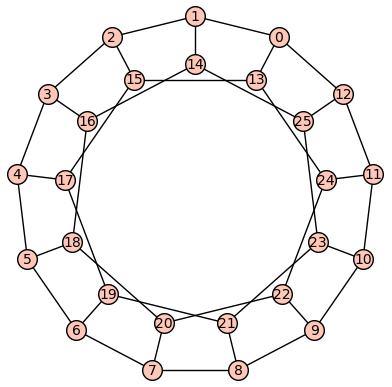

In [38]:
G5 = Graph('WdSG@CPAGG_@?_?O_CG?`?AC?CG?A??@C??P??AG??A???D')
draw_graph_ev(G1)

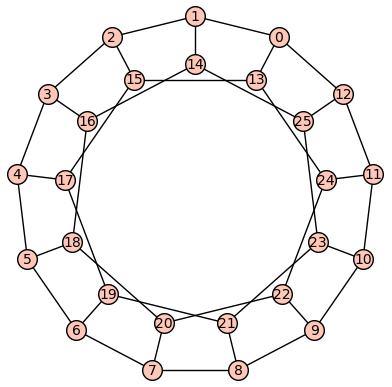

In [39]:
G6 = Graph('KrDs{[@|y|cX')
draw_graph_ev(G1)

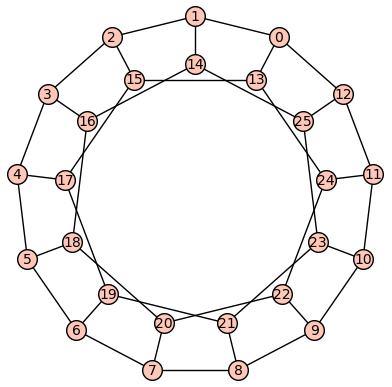

In [40]:
G7 = Graph('ShCGGC@?K?G@G@C?`?GG@?_C@?G@?G?_C')
draw_graph_ev(G1)